# ANÁLISE DA COVID-19 NO BRASIL

In [1]:
!pip3 install statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install pmdarima
#!pip install statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
#importando bibliotecas

import pandas                 as pd
import numpy                  as np
import matplotlib.pyplot      as plt
import seaborn                as sns
import plotly.express         as px
import plotly.graph_objects   as go
from datetime                 import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima

In [5]:
sns.set_style('darkgrid')

In [4]:
# configura os eixos do gráfico
def axis_settings(x_label, y_label = ' ', fontsize = 12, x_rotation = 0, y_rotation = 0):
    plt.xlabel(x_label, fontsize = fontsize)
    plt.ylabel(y_label, fontsize = fontsize)
    plt.xticks(fontsize = fontsize, rotation = x_rotation)
    plt.yticks(fontsize = fontsize, rotation = y_rotation)

In [6]:
#obtenção dos dados para analise
# link do dataset
url = 'https://github.com/neylsoncrepalde/projeto_eda_covid/blob/master/covid_19_data.csv?raw=true'

# baixando os dados e armazenando em df
df = pd.read_csv(url, parse_dates = ['ObservationDate', 'Last Update'])

In [7]:
#renomeação das colunas
df.columns = ['sno', 'observation_date', 'province_state', 'country_region', 'last_update', 'confirmed', 
              'deaths', 'recovered']

In [ ]:
#informações dos dados
df.info()

- O conjunto de dados contém 26713 linhas e 8 colunas;


In [8]:
# seleção dos dados considerando o Brasil
br = df[df['country_region'] == 'Brazil'].reset_index(drop = True)

In [9]:
# serão mantidas na base  de dados considerando caso inicial no Brasil
br = br[br['confirmed'] > 0]

In [10]:
# seleção de colunas a serem analizadas
br = br[['observation_date', 'last_update', 'confirmed', 'deaths', 'recovered']]

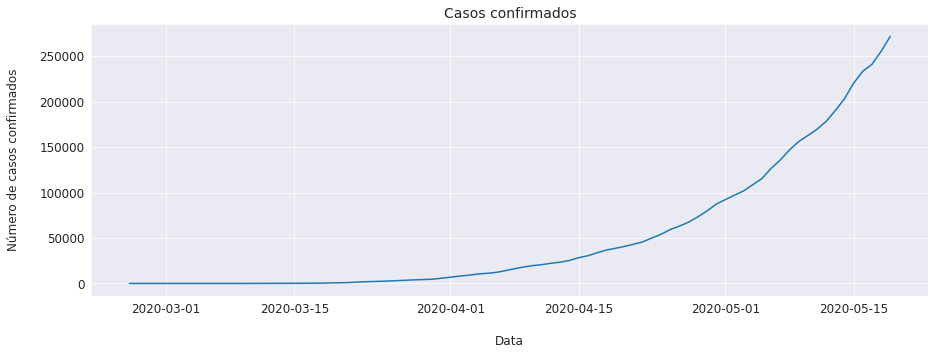

In [11]:
#casos confirmados
plt.figure(figsize = (15, 5))
sns.lineplot(data = br, x = 'observation_date', y = 'confirmed')
axis_settings('\nData', 'Número de casos confirmados\n')
plt.title('Casos confirmados', fontsize = 14)
plt.show()

Através do gráfico acima, é possível perceber que o número de casos cresce exponencialmente.

In [12]:
# contabilização do número de novos casos 
br['novos_casos'] = list(map(lambda x: 0 if (x == 0) else br['confirmed'].iloc[x] - br['confirmed'].iloc[x-1],
                        np.arange(br.shape[0])))

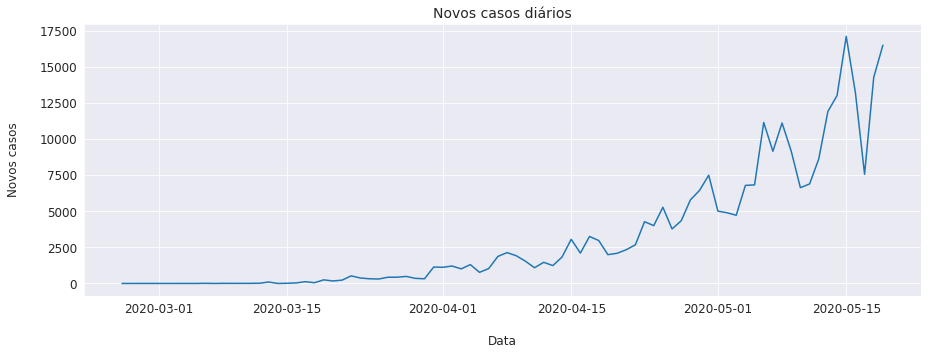

In [13]:
plt.figure(figsize = (15, 5))
sns.lineplot(data = br, x = 'observation_date', y = 'novos_casos')
axis_settings('\nData', 'Novos casos\n')
plt.title('Novos casos diários', fontsize = 14)
plt.show()

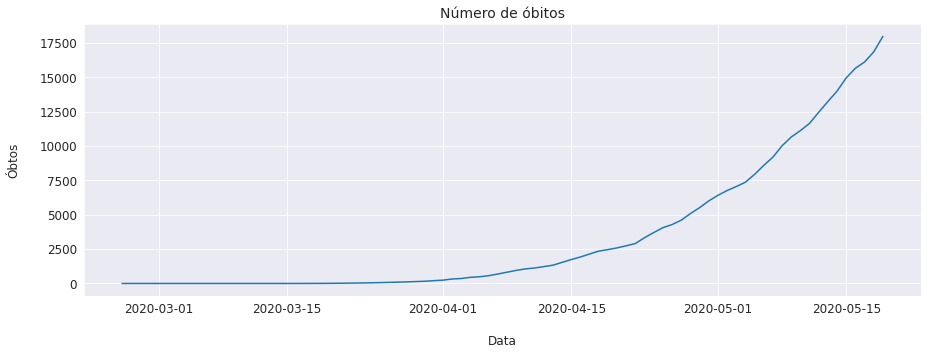

In [14]:
#quantidade de óbitos
plt.figure(figsize = (15, 5))
sns.lineplot(data = br, x = 'observation_date', y = 'deaths')
axis_settings('\nData', 'Óbtos\n')
plt.title('Número de óbitos', fontsize = 14)
plt.show()

In [15]:
def taxa_crescimento(data, variable, data_inicio = None, data_fim = None):
    # se data_inicio for None, define como a primeira data disponível no dataset
    if data_inicio == None:
        data_inicio = data.observation_date.loc[data[variable] > 0].min()
    else:
        data_inicio = pd.to_datetime(data_inicio)
        
    if data_fim == None:
        data_fim = data.observation_date.iloc[-1]
    else:
        data_fim = pd.to_datetime(data_fim)
    
    # define os valores de presente e passado
    passado = data.loc[data.observation_date == data_inicio, variable].values[0]
    presente = data.loc[data.observation_date == data_fim, variable].values[0]
    
    # define o número de pontos no tempo q vamos avaliar
    n = (data_fim - data_inicio).days
    
    # calcula a taxa
    taxa = (presente/passado)**(1/n) - 1

    return taxa*100

In [16]:
cresc_medio = taxa_crescimento(br, 'confirmed')
print(f'O crescimento médio do COVID no Brasil no período avaliado foi de {cresc_medio:.2f}%.')

O crescimento médio do COVID no Brasil no período avaliado foi de 16.27%.


In [17]:
def taxa_crescimento_diaria(data, variable, data_inicio = None):
    if data_inicio == None:
        data_inicio = data.observation_date.loc[data[variable] > 0].min()
    else:
        data_inicio = pd.to_datetime(data_inicio)
        
    data_fim = data.observation_date.max()
    n = (data_fim - data_inicio).days
    
    taxas = list(map(lambda x: (data[variable].iloc[x] - data[variable].iloc[x-1]) / data[variable].iloc[x-1],
                                range(1,n+1)))
    
    return np.array(taxas)*100

In [18]:
tx_dia = taxa_crescimento_diaria(br, 'confirmed')

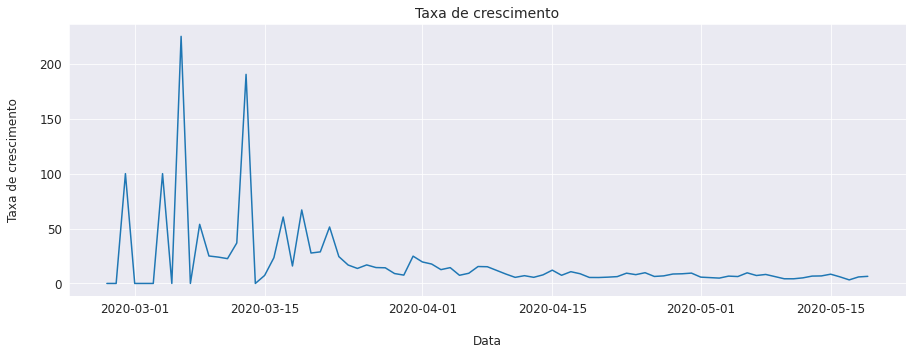

In [19]:
plt.figure(figsize = (15, 5))
primeiro_dia = br.observation_date.loc[br.confirmed > 0].min()
sns.lineplot(x = pd.date_range(primeiro_dia, br.observation_date.max())[1:], y = tx_dia)
axis_settings('\nData', 'Taxa de crescimento\n')
plt.title('Taxa de crescimento', fontsize = 14)
plt.show()

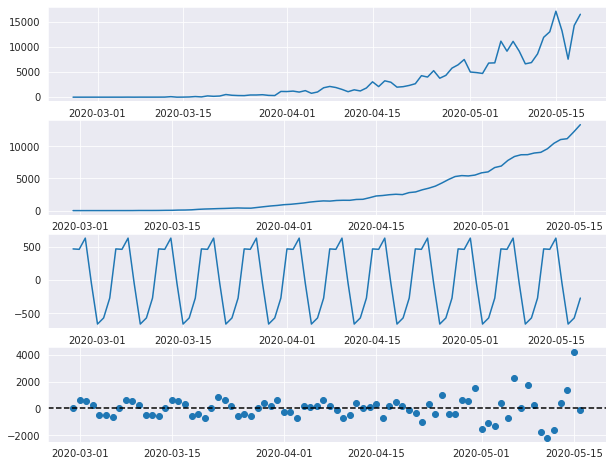

In [20]:
#Predições de novos casos

novoscasos = br.novos_casos
novoscasos.index = br.observation_date

res = seasonal_decompose(novoscasos)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize = (10,8))
ax1.plot(res.observed)
ax2.plot(res.trend)
ax3.plot(res.seasonal)
ax4.scatter(novoscasos.index, res.resid)
ax4.axhline(0, linestyle = 'dashed', c = 'black')
plt.show()

**No primeiro gráfico:** Evolução dos novos casos no período analisado.

**No segundo gráfico:** Representa uma tendência de crescimento de novos casos.

**No terceiro gráfico** A sazonalidade observada nesse caso é devida aos novos casos serem registrados nos finais de semana.

**No quarto gráfico:** Comportamentos diferentes de variabilidade da série.

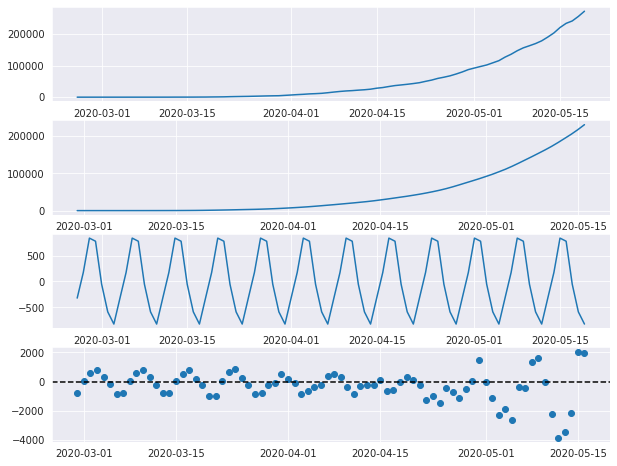

In [21]:
#casos confirmados

confirmados = br.confirmed
confirmados.index = br.observation_date

res2 = seasonal_decompose(confirmados)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize = (10,8))
ax1.plot(res2.observed)
ax2.plot(res2.trend)
ax3.plot(res2.seasonal)
ax4.scatter(confirmados.index, res2.resid)
ax4.axhline(0, linestyle = 'dashed', c = 'black')
plt.show()

### Predizendo a evolução do COVID-19

In [22]:
modelo = auto_arima(confirmados)

In [23]:
pd.date_range('2020-05-01', '2020-05-19')

DatetimeIndex(['2020-05-01', '2020-05-02', '2020-05-03', '2020-05-04',
               '2020-05-05', '2020-05-06', '2020-05-07', '2020-05-08',
               '2020-05-09', '2020-05-10', '2020-05-11', '2020-05-12',
               '2020-05-13', '2020-05-14', '2020-05-15', '2020-05-16',
               '2020-05-17', '2020-05-18', '2020-05-19'],
              dtype='datetime64[ns]', freq='D')

In [24]:
fig = go.Figure(go.Scatter(
    x=confirmados.index, y=confirmados, name='Observed'
))

fig.add_trace(go.Scatter(x=confirmados.index, y = modelo.predict_in_sample(), name='Predicted'))

fig.add_trace(go.Scatter(x=pd.date_range('2020-05-20', '2020-06-05'), y=modelo.predict(15), name='Forecast'))

fig.update_layout(title='Previsão de casos confirmados para os próximos 15 dias',
                 yaxis_title='Casos confirmados', xaxis_title='Data')
fig.show()